In [5]:
print(sp500.head())

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000


In [15]:
X_scaled

array([[-0.07815717,  0.96537057],
       [ 0.25562888,  0.87729225],
       [ 0.35305229,  0.88363636],
       ...,
       [ 0.31101077,  0.18616286],
       [ 0.67749234,  0.07301125],
       [ 0.78140973,  0.06558203]])

[*********************100%***********************]  1 of 1 completed


数据长度: 4918, 特征长度: 4918


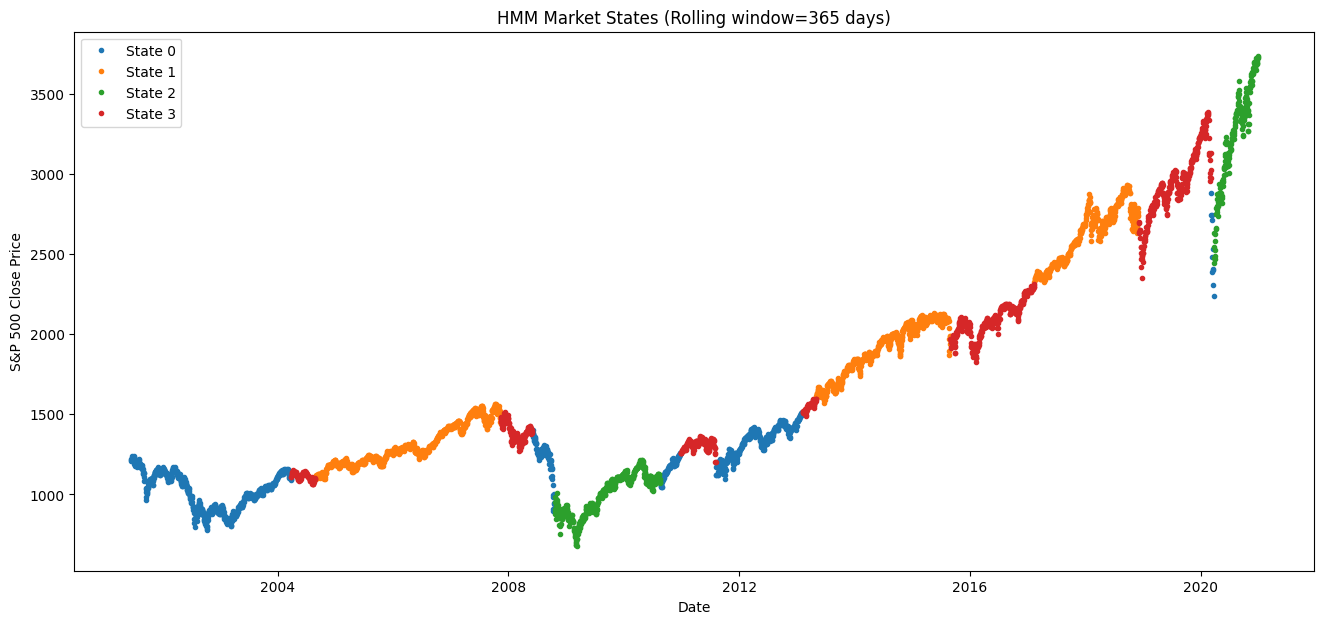

In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 下载SP500数据（2000-2020）
sp500 = yf.download('^GSPC', start='2000-01-01', end='2020-12-31')

# 计算对数收益率
sp500['log_return'] = np.log(sp500['Close']).diff()

# 设置滚动窗口大小（例如20天）
window_size = 365

# 计算滚动均值（趋势）和滚动标准差（波动）
sp500['roll_mean'] = sp500['log_return'].rolling(window=window_size).mean()
sp500['roll_std'] = sp500['log_return'].rolling(window=window_size).std()

# 删除初始NaN行（由滚动计算产生）
sp500.dropna(inplace=True)

# 使用滚动均值和标准差作为HMM的特征
X = sp500[['roll_mean', 'roll_std']].values

# 特征标准化（HMM模型表现更好）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 检查数据长度是否一致
print(f"数据长度: {len(sp500)}, 特征长度: {len(X_scaled)}")
assert len(sp500) == len(X_scaled), "长度不匹配！"

# 构建和训练HMM模型（4个市场状态）
hmm_model = GaussianHMM(n_components=4, covariance_type='full', n_iter=500, random_state=42)
hmm_model.fit(X_scaled)

# 预测市场状态
states = hmm_model.predict(X_scaled)

# 状态标记添加到原数据中
sp500['HMM_state'] = states

# 可视化HMM状态（滚动窗口特征版）
plt.figure(figsize=(16, 7))
for i in range(hmm_model.n_components):
    idx = sp500['HMM_state'] == i
    plt.plot(sp500.index[idx], sp500['Close'][idx], '.', label=f'State {i}')

plt.title(f'HMM Market States (Rolling window={window_size} days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


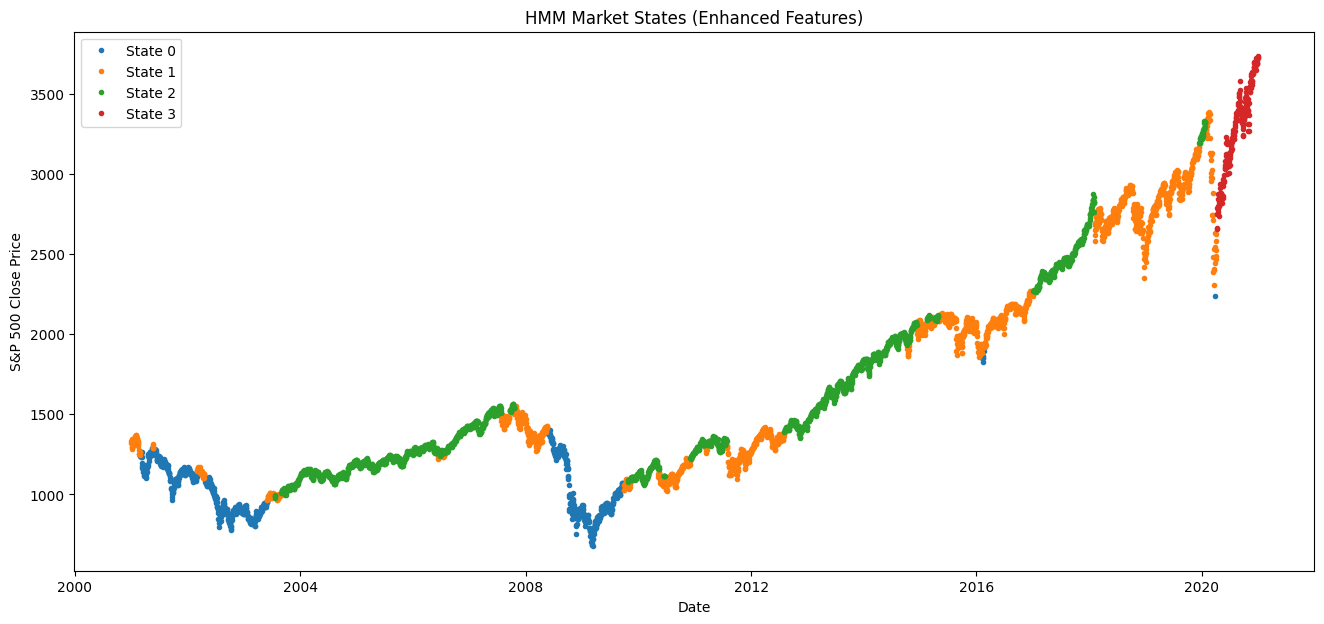

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 下载SP500和VIX指数数据（2000-2020）
sp500 = yf.download('^GSPC', start='2000-01-01', end='2020-12-31')
vix = yf.download('^VIX', start='2000-01-01', end='2020-12-31')

# 数据预处理和对齐
sp500['log_return'] = np.log(sp500['Close']).diff()

# 设置滚动窗口大小
window_size = 250

# 基础滚动特征
sp500['roll_mean'] = sp500['log_return'].rolling(window=window_size).mean()
sp500['roll_std'] = sp500['log_return'].rolling(window=window_size).std()

# 新增特征1：滚动动量 (Momentum)
sp500['momentum'] = sp500['Close'].pct_change(periods=window_size)

# 新增特征2：真实波动幅度（ATR）
sp500['TR'] = np.maximum.reduce([
    sp500['High'] - sp500['Low'],
    abs(sp500['High'] - sp500['Close'].shift(1)),
    abs(sp500['Low'] - sp500['Close'].shift(1))
])
sp500['ATR'] = sp500['TR'].rolling(window=window_size).mean()

# 新增特征3：VIX指数（市场情绪）
sp500['VIX'] = vix['Close']

# 删除NaN，特征对齐
sp500.dropna(inplace=True)

# 特征矩阵构建
features = ['roll_mean', 'roll_std', 'momentum', 'ATR', 'VIX']
X = sp500[features].values

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# HMM模型训练（4个状态）
hmm_model = GaussianHMM(n_components=4, covariance_type='full', n_iter=500, random_state=42)
hmm_model.fit(X_scaled)

# 预测市场状态
states = hmm_model.predict(X_scaled)
sp500['HMM_state'] = states

# 可视化市场状态
plt.figure(figsize=(16, 7))
for i in range(hmm_model.n_components):
    idx = sp500['HMM_state'] == i
    plt.plot(sp500.index[idx], sp500['Close'][idx], '.', label=f'State {i}')

plt.title('HMM Market States (Enhanced Features)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


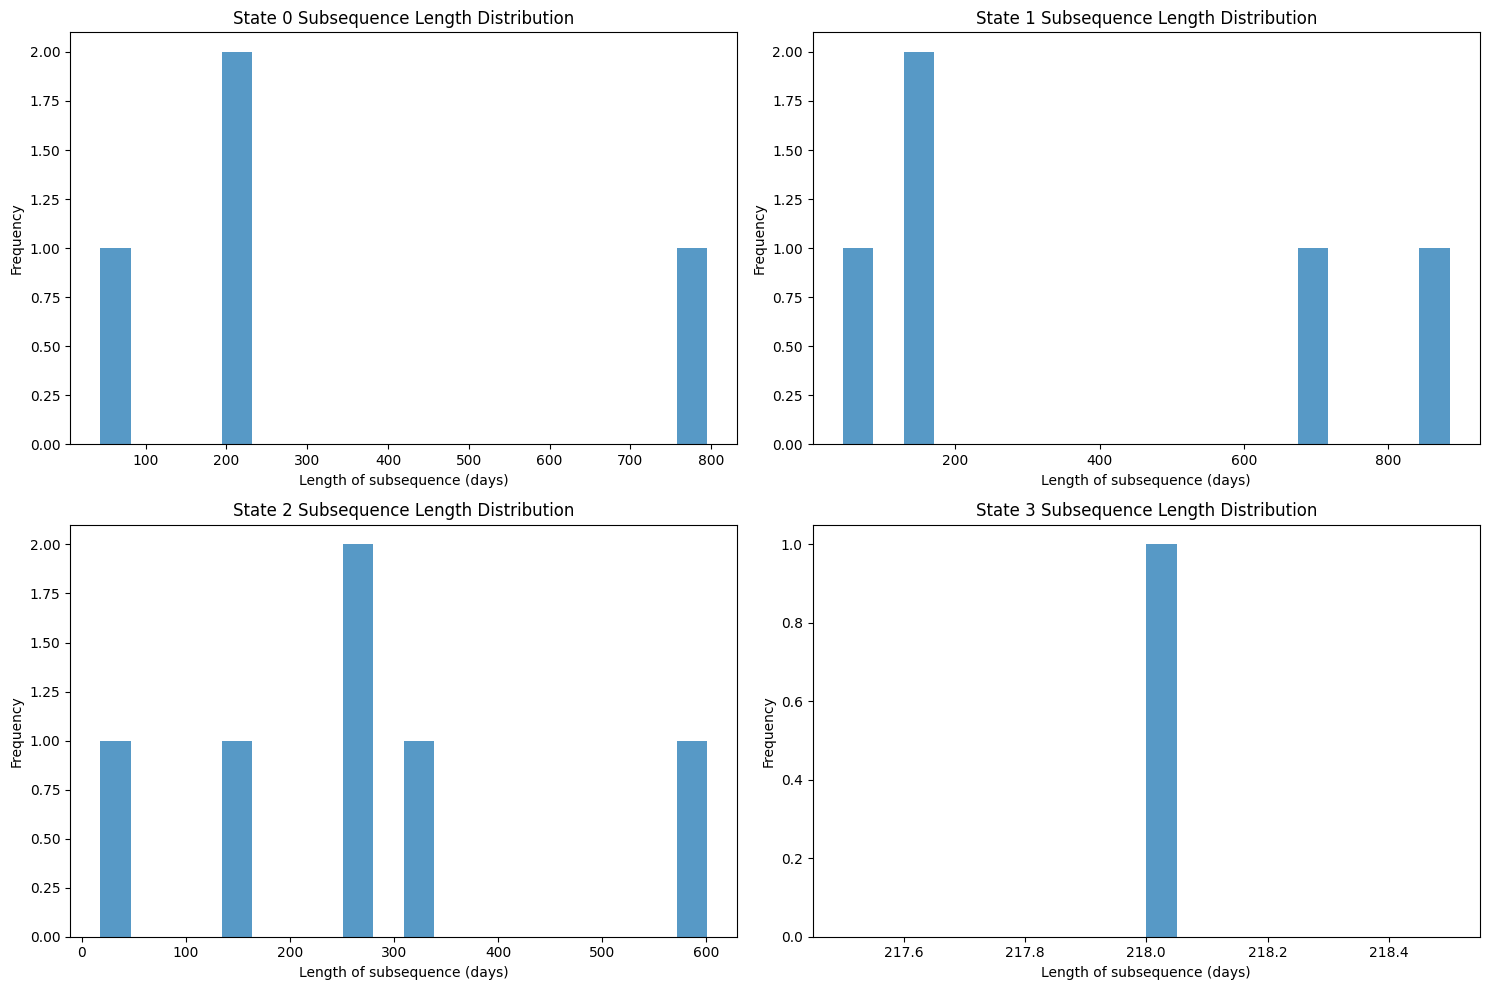

In [28]:
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 下载SP500和VIX指数数据（2000-2020）
sp500 = yf.download('^GSPC', start='2000-01-01', end='2020-12-31')
vix = yf.download('^VIX', start='2000-01-01', end='2020-12-31')

# 数据预处理
sp500['log_return'] = np.log(sp500['Close']).diff()

window_size = 250
sp500['roll_mean'] = sp500['log_return'].rolling(window=window_size).mean()
sp500['roll_std'] = sp500['log_return'].rolling(window=window_size).std()
sp500['momentum'] = sp500['Close'].pct_change(periods=window_size)

sp500['TR'] = np.maximum.reduce([
    sp500['High'] - sp500['Low'],
    abs(sp500['High'] - sp500['Close'].shift(1)),
    abs(sp500['Low'] - sp500['Close'].shift(1))
])
sp500['ATR'] = sp500['TR'].rolling(window=window_size).mean()

sp500['VIX'] = vix['Close']
sp500.dropna(inplace=True)

features = ['roll_mean', 'roll_std']
X = sp500[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

hmm_model = GaussianHMM(n_components=4, covariance_type='full', n_iter=1000, random_state=42)
hmm_model.fit(X_scaled)
states = hmm_model.predict(X_scaled)
sp500['HMM_state'] = states

# 计算每个状态子序列的长度分布
state_lengths = {state: [] for state in np.unique(states)}
current_state = states[0]
length = 1

for s in states[1:]:
    if s == current_state:
        length += 1
    else:
        state_lengths[current_state].append(length)
        current_state = s
        length = 1
# 添加最后一个序列长度
state_lengths[current_state].append(length)

# 绘制每个状态子序列长度分布图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for state, ax in zip(state_lengths.keys(), axes):
    ax.hist(state_lengths[state], bins=20, alpha=0.75)
    ax.set_title(f'State {state} Subsequence Length Distribution')
    ax.set_xlabel('Length of subsequence (days)')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Model is not converging.  Current: 861.9174393106609 is not greater than 861.920834572457. Delta is -0.003395261796072191
Model is not converging.  Current: 770.639409207791 is not greater than 770.6397041738754. Delta is -0.00029496608442514116
Model is not converging.  Current: 643.6577985233047 is not greater than 643.6688472253309. Delta is -0.01104870202618713
Model is not converging.  Current: 1869.5140239304599 is not greater than 1869.5242644631753. Delta is -0.010240532715442896
Model is not converging.  Current: 2030.5834897912878 is not greater than 2033.1161237758165. Delta is -2.5326339845287293
Model is not converging.  Current: 2250.3354967667988 is not greater than 2250.550531673989. Delta is -0.21503490719032925
Model is not converging.  Current: -225.29218715681017 is not greater than -225.2870650700886. Delta is -0.0051220867215704

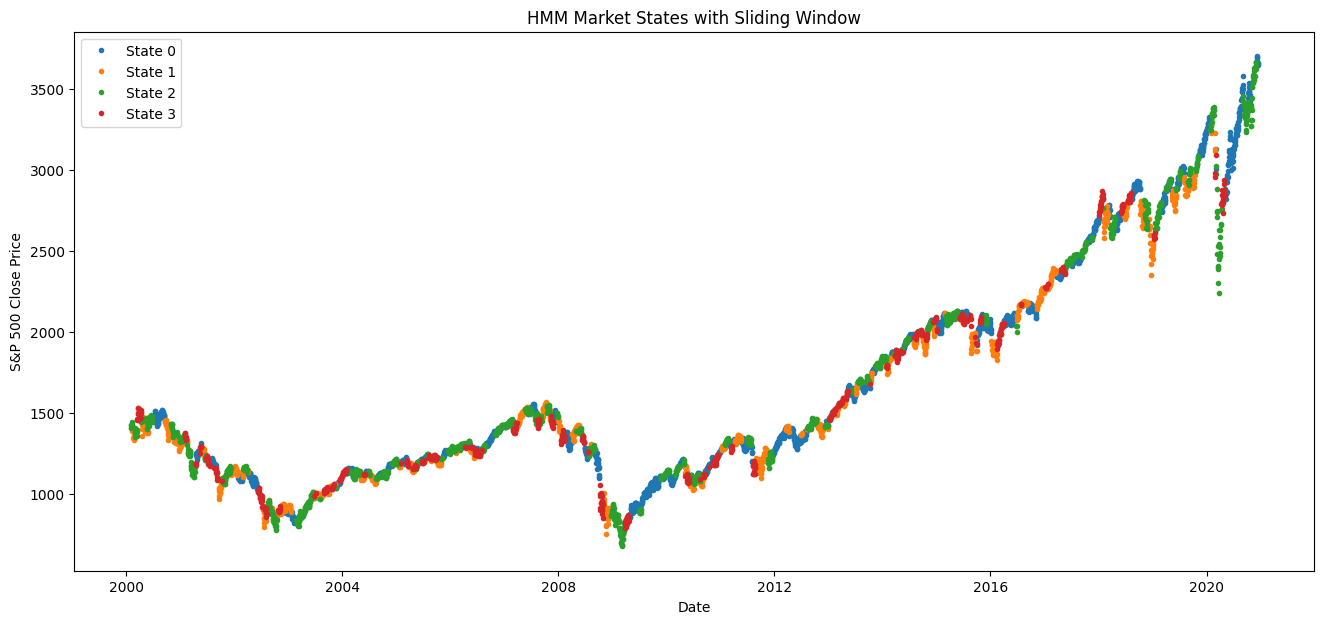

In [32]:
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 下载SP500数据（2000-2020）
sp500 = yf.download('^GSPC', start='2000-01-01', end='2020-12-31')
vix = yf.download('^VIX', start='2000-01-01', end='2020-12-31')

# 数据预处理
sp500['log_return'] = np.log(sp500['Close']).diff()

window_size = 20
sp500['roll_mean'] = sp500['log_return'].rolling(window=window_size).mean()
sp500['roll_std'] = sp500['log_return'].rolling(window=window_size).std()
sp500['momentum'] = sp500['Close'].pct_change(periods=window_size)

sp500['TR'] = np.maximum.reduce([
    sp500['High'] - sp500['Low'],
    abs(sp500['High'] - sp500['Close'].shift(1)),
    abs(sp500['Low'] - sp500['Close'].shift(1))
])
sp500['ATR'] = sp500['TR'].rolling(window=window_size).mean()

sp500['VIX'] = vix['Close']
sp500.dropna(inplace=True)

features = ['roll_mean', 'roll_std', 'momentum', 'ATR', 'VIX']
X = sp500[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 定义滑动窗口参数（例如，每个窗口1年约252交易日，滑动步长为1个月约21交易日）
win_length = 252
step_size = 100

n_windows = (len(X_scaled) - win_length) // step_size + 1
all_states = np.full(len(X_scaled), np.nan)

# 对每个窗口单独训练并预测状态
for i in range(n_windows):
    start_idx = i * step_size
    end_idx = start_idx + win_length
    
    window_X = X_scaled[start_idx:end_idx]
    
    hmm = GaussianHMM(n_components=4, covariance_type='full', n_iter=300, random_state=42)
    hmm.fit(window_X)
    window_states = hmm.predict(window_X)
    
    # 将窗口最后一个步长的状态保存下来（避免过多重叠）
    if i == 0:
        all_states[start_idx:end_idx] = window_states
    else:
        all_states[end_idx-step_size:end_idx] = window_states[-step_size:]

# 将预测的状态填入数据
sp500['Sliding_HMM_state'] = all_states

# 可视化（滑动窗口预测的状态）
plt.figure(figsize=(16, 7))
unique_states = np.unique(sp500['Sliding_HMM_state'][~np.isnan(sp500['Sliding_HMM_state'])])
colors = plt.cm.tab10.colors

for state in unique_states:
    idx = sp500['Sliding_HMM_state'] == state
    plt.plot(sp500.index[idx], sp500['Close'][idx], '.', label=f'State {int(state)}', color=colors[int(state)])

plt.title('HMM Market States with Sliding Window')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()


In [33]:
# 定义滑动窗口参数（例如，每个窗口1年252交易日，滑动步长1个月21交易日）
win_length = 252
step_size = 21

n_windows = (len(sp500) - win_length) // step_size + 1

window_metrics = []  # 用于存储每个窗口的指标
window_dates = []    # 存储窗口的结束日期

for i in range(n_windows):
    start_idx = i * step_size
    end_idx = start_idx + win_length
    
    window_data = sp500.iloc[start_idx:end_idx]
    
    # 计算窗口的mean return 和 volatility
    mean_return = window_data['log_return'].mean()
    volatility = window_data['log_return'].std()
    
    # 保存结果
    window_metrics.append({
        'mean_return': mean_return,
        'volatility': volatility
    })
    # 用窗口最后一天作为窗口日期标识
    window_dates.append(window_data.index[-1])

# 转换为DataFrame
df_metrics = pd.DataFrame(window_metrics, index=window_dates)

# 显示结果
print(df_metrics.head())



            mean_return  volatility
2001-01-30    -0.000059    0.013944
2001-03-01    -0.000418    0.013859
2001-03-30    -0.000987    0.013953
2001-05-01    -0.000587    0.013869
2001-05-31    -0.000489    0.013477


Cluster Centers:
   mean_return  volatility
0     0.000481    0.008214
1    -0.000722    0.013710
2     0.000289    0.017378
3    -0.001621    0.027105


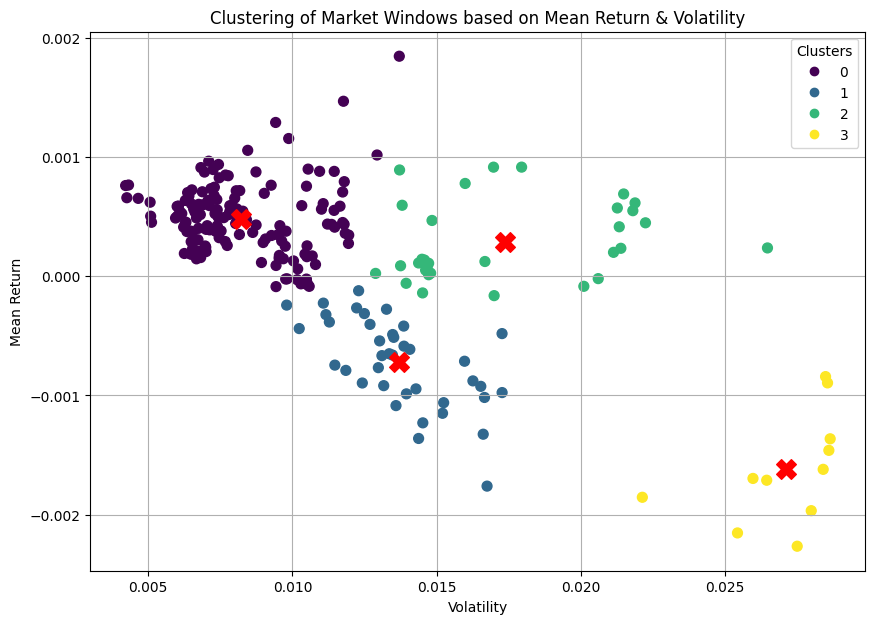

            mean_return  volatility  Cluster
2001-01-30    -0.000059    0.013944        2
2001-03-01    -0.000418    0.013859        1
2001-03-30    -0.000987    0.013953        1
2001-05-01    -0.000587    0.013869        1
2001-05-31    -0.000489    0.013477        1
2001-06-29    -0.000650    0.013357        1
2001-07-31    -0.000661    0.013469        1
2001-08-29    -0.001085    0.013592        1
2001-10-04    -0.001230    0.014522        1
2001-11-02    -0.000945    0.014284        1


In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 数据准备
X_cluster = df_metrics[['mean_return', 'volatility']].values

# 标准化数据（必需）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 使用KMeans聚类（假设聚类为4类，对应牛市、熊市、震荡市、平稳市）
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
df_metrics['Cluster'] = kmeans.fit_predict(X_scaled)

# 输出聚类中心（用于解释）
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=['mean_return', 'volatility'])
print("Cluster Centers:")
print(centers_df)

# 可视化聚类结果
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_metrics['volatility'], df_metrics['mean_return'],
                      c=df_metrics['Cluster'], cmap='viridis', s=50)

# 标注聚类中心
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], c='red', marker='X', s=200, label='Centroids')

plt.xlabel('Volatility')
plt.ylabel('Mean Return')
plt.title('Clustering of Market Windows based on Mean Return & Volatility')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

# 查看DataFrame中聚类标记
print(df_metrics.head(10))


In [39]:

import os
import numpy as np
import pandas as pd
import pickle
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression

def smooth_data(data):
    N, Wn = 1, 0.05
    b, a = butter(N, Wn, btype='low')
    return filtfilt(b, a, data)

def get_slope(smoothed_data):
    X = np.arange(len(smoothed_data)).reshape(-1, 1)
    model = LinearRegression().fit(X, smoothed_data)
    return model.coef_[0]

def calculate_slopes(df, chunk_size):
    slopes = []
    for i in range(len(df) // chunk_size):
        chunk = df['Close'].iloc[i*chunk_size:(i+1)*chunk_size].values
        smoothed_chunk = smooth_data(chunk)
        slope = get_slope(smoothed_chunk)
        slopes.append(slope)
    return slopes

def calculate_volatility(df, chunk_size):
    volatilities = []
    for i in range(len(df) // chunk_size):
        chunk = df['Close'].iloc[i*chunk_size:(i+1)*chunk_size]
        returns = chunk.pct_change().dropna()
        volatility = returns.std()
        volatilities.append(volatility)
    return volatilities

def label_quantiles(values, quantiles=[0, 0.05, 0.35, 0.65, 0.95, 1]):
    labels, bins = pd.qcut(values, q=quantiles, retbins=True, labels=False)
    return labels, bins

def save_labels(labels, path):
    indices = [[] for _ in range(len(np.unique(labels)))]
    for idx, label in enumerate(labels):
        indices[label].append(idx)
    with open(path, 'wb') as file:
        pickle.dump(indices, file)

def chunk_and_label(df, chunk_size, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # Chunk数据并保存
    for i in range(len(df) // chunk_size):
        df_chunk = df.iloc[i*chunk_size:(i+1)*chunk_size].reset_index(drop=True)
        df_chunk.to_feather(f'{save_dir}/df_{i}.feather')

    # 计算趋势和波动率
    slopes = calculate_slopes(df, chunk_size)
    vols = calculate_volatility(df, chunk_size)

    # 生成labels并保存
    slope_labels, _ = label_quantiles(slopes)
    vol_labels, _ = label_quantiles(vols)

    save_labels(slope_labels, f'{save_dir}/slope_labels.pkl')
    save_labels(vol_labels, f'{save_dir}/vol_labels.pkl')

# 直接调用函数即可，无需修改源代码
if __name__ == '__main__':
    df = pd.read_csv('data.csv', parse_dates=['Date'])
    chunk_and_label(df, chunk_size=252, save_dir='./output')



FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'